# From tokens to numbers: the document-term matrix

The bag of words model represents a document based on the frequency of the terms or tokens it contains. Each document becomes a vector with one entry for each token in the vocabulary that reflects the token’s relevance to the document.

The document-term matrix is straightforward to compute given the vocabulary. However, it is also a crude simplification because it abstracts from word order and grammatical relationships. Nonetheless, it often achieves good results in text classification quickly and, thus, a very useful starting point.

There are several ways to weigh a token’s vector entry to capture its relevance to the document. We will illustrate below how to use sklearn to use binary flags that indicate presence or absence, counts, and weighted counts that account for differences in term frequencies across all documents, i.e., in the corpus. 

## Imports & Settings

In [1]:
using Pkg

In [2]:
#Pkg.add("Glob")
#Pkg.add("DataFrames")
#Pkg.add("StringEncodings")
#Pkg.add("TextAnalysis")
#Pkg.add("Plots")
#Pkg.add("SciPy")
#Pkg.add("Wordnet")
#Pkg.add("Seaborn")
#Pkg.add("DataStructures")

In [3]:
using PyCall
using Conda

In [4]:
using ScikitLearn

In [5]:
using ScikitLearn: @sk_import

In [6]:
@sk_import feature_extraction.text: CountVectorizer
@sk_import feature_extraction.text: TfidfVectorizer
@sk_import feature_extraction.text: TfidfTransformer
@sk_import model_selection: train_test_split

┌ Warning: Module model_selection has been ported to Julia - try `import ScikitLearn: CrossValidation` instead
└ @ ScikitLearn.Skcore C:\Users\Amirreza\.julia\packages\ScikitLearn\Kn82b\src\Skcore.jl:169


PyObject <function train_test_split at 0x000000007F094430>

In [7]:
using Glob
using DataFrames
using TextAnalysis
using StringEncodings
using Plots
using SciPy
using WordNet
using Seaborn
using DataStructures
using StatsBase

In [8]:
using MLJ
using MLJText

## Load BBC data

In [9]:
files = Glob.glob("../data/bbc/bbc/**/*.txt")

2225-element Vector{String}:
 "..\\data\\bbc\\bbc\\business\\001.txt"
 "..\\data\\bbc\\bbc\\business\\002.txt"
 "..\\data\\bbc\\bbc\\business\\003.txt"
 "..\\data\\bbc\\bbc\\business\\004.txt"
 "..\\data\\bbc\\bbc\\business\\005.txt"
 "..\\data\\bbc\\bbc\\business\\006.txt"
 "..\\data\\bbc\\bbc\\business\\007.txt"
 "..\\data\\bbc\\bbc\\business\\008.txt"
 "..\\data\\bbc\\bbc\\business\\009.txt"
 "..\\data\\bbc\\bbc\\business\\010.txt"
 "..\\data\\bbc\\bbc\\business\\011.txt"
 "..\\data\\bbc\\bbc\\business\\012.txt"
 "..\\data\\bbc\\bbc\\business\\013.txt"
 ⋮
 "..\\data\\bbc\\bbc\\tech\\390.txt"
 "..\\data\\bbc\\bbc\\tech\\391.txt"
 "..\\data\\bbc\\bbc\\tech\\392.txt"
 "..\\data\\bbc\\bbc\\tech\\393.txt"
 "..\\data\\bbc\\bbc\\tech\\394.txt"
 "..\\data\\bbc\\bbc\\tech\\395.txt"
 "..\\data\\bbc\\bbc\\tech\\396.txt"
 "..\\data\\bbc\\bbc\\tech\\397.txt"
 "..\\data\\bbc\\bbc\\tech\\398.txt"
 "..\\data\\bbc\\bbc\\tech\\399.txt"
 "..\\data\\bbc\\bbc\\tech\\400.txt"
 "..\\data\\bbc\\bbc\\tech\\

In [10]:
doc_list = Any[]
for (i,file) in enumerate(files)
    f = open(file,"r")
    s = StringDecoder(f,"LATIN1", "UTF-8")
    topic = split(file, "\\")[end-1]
    lines = readlines(s)
    heading = strip(lines[1])
    body = strip(join([strip(line) for line in lines[2:end]]))
    push!(doc_list, [topic, heading, body])
    close(s)
    close(f)
end

### Convert to DataFrame

In [11]:
docs = DataFrame(topic = [String(x[1]) for x in doc_list], heading = [String(x[2]) for x in doc_list], body = [String(x[3]) for x in doc_list])

,topic,heading,body
,String,String,String
1,business,Ad sales boost Time Warner profit,"Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.Time Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. ""Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,"" chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.TimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake."
2,business,Dollar gains on Greenspan speech,"The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.And Alan Greenspan highlighted the US government's willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan's speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. ""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York. ""He's taking a longer-term view, laying out a set of conditions under which the current account deficit can improve this year and next.""Worries about the deficit concerns about China do, however, remain. China's currency remains pegged to the dollar and the US currency's sharp falls in recent months have therefore made Chinese export prices highly competitive. But calls for a shift in Beijing's policy have fallen on deaf ears, despite recent comments

### Inspect results

In [12]:
using Random

article = docs[shuffle(1:nrow(docs))[1:5], :]

,topic,heading,body
,String,String,String
1,sport,O'Connor aims to grab opportunity,"Johnny O'Connor is determined to make a big impression when he makes his RBS Six Nations debut for Ireland against Scotland on Saturday.The Wasps flanker replaces Denis Leamy but O'Connor knows that the Munster man will be pushing hard for a recall for the following game against England. ""It's a 'horses for courses' selection really,"" said O'Connor. ""There's a lot of competition here and I can't just drag my heels around if I don't get picked."" It looks a definite head-to-head battle between himself and 23-year-old Leamy - three stone heavier than O'Connor - for the number seven role against the world champions. Nonetheless, all O'Connor is currently concerned about is making an impression while winning his third cap.""Missing the Italian game was disappointing certainly, but you can't dwell on these things - it's part and parcel of rugby. ""Denis has been playing really well and deserved his opportunity. ""It's a good situation to be in if there are good players around you, pushing for a place in the side."" O'Connor, who celebrated his 25th birthday on Wednesday, was touted by Wasps director of rugby Warren Gatland as a possible 2005 Lions Test openside as far back as last September. And his reputation as a breakdown scavenger and heavy hitter has seen him come to the forefront of O'Sullivan's mind for the Scottish tussle. O'Connor added: ""It will be interesting to see how situations on the deck is reffed, with the new laws having come in.""Obviously the breakdown a big part of what I do on the pitch so I'm hoping to hold some influence there against what is a very solid Scottish pack."" O'Connor will be winning his third cap after making his debut in the victory over South Africa last November."
2,business,GM in crunch talks on Fiat future,"Fiat will meet car giant General Motors (GM) on Tuesday in an attempt to reach agreement over the future of the Italian firm's loss-making auto group.Fiat claims that GM is legally obliged to buy the 90% of the car unit it does not already own; GM says the contract, signed in 2000, is no longer valid. Press reports have speculated that Fiat may be willing to accept a cash payment in return for dropping its claim. Both companies want to cut costs as the car industry adjusts to waning demand.The meeting between Fiat boss Sergio Marchionne and GM's Rick Wagoner is due to take place at 1330 GMT in Zurich, according to the Reuters news agency.Mr Marchionne is confident of his firm's legal position, saying in an interview with the Financial Times that GM's argument ""has no legs"". The agreement in question dates back to GM's decision to buy 20% of Fiat's auto division in 2000. At the time, it gave the Italian firm the right, via a 'put option', to sell the remaining stake to GM. In recent weeks, Fiat has reiterated its claims that this 'put' is still valid and legally binding. However, GM argues that a Fiat share sale made last year, which cut GM's holding to 10%, together with asset sales made by Fiat have terminated the agreement.Selling the Fiat's car-making unit may not prove so simple, analysts say, especially as it is a company that is so closely linked to Italy's industrial heritage. Political and public pressure may well push the two firms to reach a compromise. ""We are not expecting Fiat to exercise its put of the auto business against an unwilling GM at this point,"" brokerage Merrill Lynch said in a note to investors, adding that any legal battle would be protracted and damaging to the business. ""As far as we are aware, the Agnelli family, which indirectly controls at least 30% of Fiat, has not given a firm public indication that it wants to sell the auto business. ""Fiat may be willing to cancel the 'put' in exchange for money."""
3,tech,IBM puts cash behind Linux push,"IBM is spending $100m (Â£52m) over the next three years beefing up its commitment to Linux software.The cash injection wil

### Data drawn from 5 different categories

In [13]:
docs_count = combine(groupby(docs, [:topic]), nrow => :count)
docs_count[:, :count_percentage] = docs_count.count/sum(docs_count.count)*100
docs_count

,topic,count,count_percentage
,String,Int64,Float64
1,business,510,22.9213
2,entertainment,386,17.3483
3,politics,417,18.7416
4,sport,511,22.9663
5,tech,401,18.0225


## Explore Corpus

### Token Count via Counter()

In [14]:
word_count = length(split(join(string.(docs.body))))
word_per_article = word_count/nrow(docs)

using Printf 
@printf("Total word count: %.0f | per article: %.0f", word_count, word_per_article)

Total word count: 832276 | per article: 374

In [15]:
word_list = split(join(string.(docs.body)))
word_list = strip.(word_list)
filter!(!isempty, word_list)

832276-element Vector{SubString{String}}:
 "Quarterly"
 "profits"
 "at"
 "US"
 "media"
 "giant"
 "TimeWarner"
 "jumped"
 "76%"
 "to"
 "\$1.13bn"
 "(Â£600m)"
 "for"
 ⋮
 "Ultima"
 "Online"
 "was"
 "the"
 "game,"
 "ahhhh"
 "them"
 "was"
 "the"
 "days"
 "!"
 "LOL"

In [16]:
word_count_dict = Dict(word => count(isequal(word), word_list) for word in unique(word_list))

Dict{SubString{String}, Int64} with 71227 entries:
  "neighbours."      => 1
  "screen.\"I"       => 1
  "backlogs,"        => 1
  "bid.The"          => 3
  "common\"."        => 1
  "show.But"         => 1
  "do\","            => 1
  "Claassens,"       => 1
  "valuation."       => 1
  "worthwhile.Hugo"  => 2
  "does;"            => 1
  "side.\"I'm"       => 1
  "3-2."             => 2
  "gathered"         => 38
  "one-two"          => 2
  "machine.It"       => 2
  "Blunkett"         => 65
  "Mendelsohn,"      => 1
  "little,"          => 4
  "3,248"            => 1
  "underground"      => 12
  "over-reacted"     => 3
  "\"pioneers\""     => 2
  "quarter.Speaking" => 1
  "ADVANCE"          => 1
  ⋮                  => ⋮

In [17]:
count_list = [word_count_dict[word] for word in unique(word_list)]

71227-element Vector{Int64}:
     2
   118
  4329
  1176
   216
   142
     6
    32
     2
 24460
     2
     1
  8423
     ⋮
     1
     1
     1
     1
     1
     1
     1
     1
     1
     1
     1
     1

In [18]:
word_count_df = sort(DataFrame(tokens = unique(word_list), count = count_list), :count, rev=true)

,tokens,count
,SubStrin…,Int64
1,the,44431
2,to,24460
3,of,19754
4,and,17865
5,a,17115
6,in,16313
7,is,8426
8,for,8423
9,that,7528


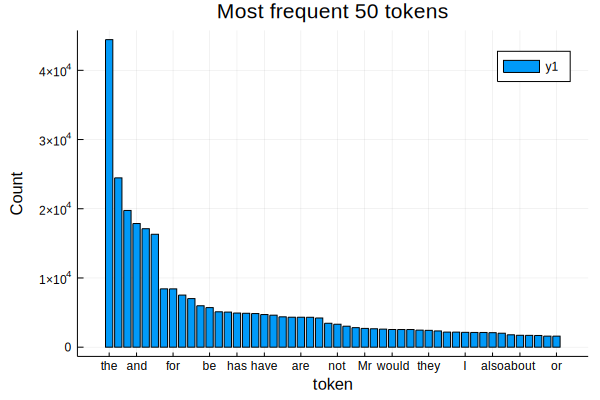

In [19]:
Plots.bar(word_count_df.tokens[1:50], word_count_df.count[1:50])
Plots.ylabel!("Count")
Plots.xlabel!("token")
Plots.title!("Most frequent 50 tokens")

## Document-Term Matrix with `CountVectorizer`

The scikit-learn preprocessing module offers two tools to create a document-term matrix. The [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) uses binary or absolute counts to measure the term frequency tf(d, t) for each document d and token t.

The [TfIDFVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), in contrast, weighs the (absolute) term frequency by the inverse document frequency (idf). As a result, a term that appears in more documents will receive a lower weight than a token with the same frequency for a given document but lower frequency across all documents. 

The resulting tf-idf vectors for each document are normalized with respect to their absolute or squared totals (see the sklearn documentation for details). The tf-idf measure was originally used in information retrieval to rank search engine results and has subsequently proven useful for text classification or clustering.

Both tools use the same interface and perform tokenization and further optional preprocessing of a list of documents before vectorizing the text by generating token counts to populate the document-term matrix.

Key parameters that affect the size of the vocabulary include:

- `stop_words`: use a built-in or provide a list of (frequent) words to exclude
- `ngram_range`: include n-grams in a range for n defined by a tuple of (nmin, nmax)
- `lowercase`: convert characters accordingly (default is True)
- `min_df `/ max_df: ignore words that appear in less / more (int) or a smaller / larger share of documents (if float [0.0,1.0])
- `max_features`: limit number of tokens in vocabulary accordingly
- `binary`: set non-zero counts to 1 True

### Key parameters

In [20]:
?DocumentTermMatrix

search: DocumentTermMatrix



```
DocumentTermMatrix(crps::Corpus)
DocumentTermMatrix(crps::Corpus, terms::Vector{String})
DocumentTermMatrix(crps::Corpus, lex::AbstractDict)
DocumentTermMatrix(dtm::SparseMatrixCSC{Int, Int},terms::Vector{String})
```

Represent documents as a matrix of word counts.

Allow us to apply linear algebra operations and statistical techniques. Need to update lexicon before use.

# Examples

```julia-repl
julia> crps = Corpus([StringDocument("To be or not to be"),
                      StringDocument("To become or not to become")])

julia> update_lexicon!(crps)

julia> m = DocumentTermMatrix(crps)
A 2 X 6 DocumentTermMatrix

julia> m.dtm
2×6 SparseArrays.SparseMatrixCSC{Int64,Int64} with 10 stored entries:
  [1, 1]  =  1
  [2, 1]  =  1
  [1, 2]  =  2
  [2, 3]  =  2
  [1, 4]  =  1
  [2, 4]  =  1
  [1, 5]  =  1
  [2, 5]  =  1
  [1, 6]  =  1
  [2, 6]  =  1
```


In [21]:
println(CountVectorizer().__doc__)

Convert a collection of text documents to a matrix of token counts.

    This implementation produces a sparse representation of the counts using
    scipy.sparse.csr_matrix.

    If you do not provide an a-priori dictionary and you do not use an analyzer
    that does some kind of feature selection then the number of features will
    be equal to the vocabulary size found by analyzing the data.

    Read more in the :ref:`User Guide <text_feature_extraction>`.

    Parameters
    ----------
    input : {'filename', 'file', 'content'}, default='content'
        - If `'filename'`, the sequence passed as an argument to fit is
          expected to be a list of filenames that need reading to fetch
          the raw content to analyze.

        - If `'file'`, the sequence items must have a 'read' method (file-like
          object) that is called to fetch the bytes in memory.

        - If `'content'`, the input is expected to be a sequence of items that
          can be of type string or 

### Document Frequency Distribution

In [22]:
body_text = [StringDocument(x) for x in docs.body]
crps = Corpus(body_text)

A Corpus with 2225 documents:
 * 2225 StringDocument's
 * 0 FileDocument's
 * 0 TokenDocument's
 * 0 NGramDocument's

Corpus's lexicon contains 0 tokens
Corpus's index contains 0 tokens

In [23]:
documents = crps.documents
documents[1]

A StringDocument{String}
 * Language: Languages.English()
 * Title: Untitled Document
 * Author: Unknown Author
 * Timestamp: Unknown Time
 * Snippet: Quarterly profits at US media giant TimeWarner jum

In [24]:
update_lexicon!(crps)

In [25]:
dtv(crps[1], lexicon(crps))

1×48231 Matrix{Int64}:
 0  2  0  9  0  8  0  5  2  2  0  0  …  0  0  0  0  0  0  0  0  0  0  1  1

In [26]:
doc_term_matrix = DocumentTermMatrix(crps)
doc_term_matrix = dtm(doc_term_matrix)

2225×48231 SparseArrays.SparseMatrixCSC{Int64, Int64} with 497056 stored entries:
⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿

In [27]:
size(doc_term_matrix)

(2225, 48231)

### CountVectorizer

In [28]:
binary_vectorizer = CountVectorizer(max_df=1.0,
                                    min_df=1,
                                    binary=true)

binary_dtm = binary_vectorizer.fit_transform(docs.body)

PyObject <2225x29447 sparse matrix of type '<class 'numpy.int64'>'
	with 445887 stored elements in Compressed Sparse Row format>

In [29]:
binary_dtm

PyObject <2225x29447 sparse matrix of type '<class 'numpy.int64'>'
	with 445887 stored elements in Compressed Sparse Row format>

In [30]:
n_docs, n_tokens = binary_dtm.shape

(2225, 29447)

In [31]:
tokens_dtm = binary_vectorizer.get_feature_names()

C:\Users\Amirreza\.julia\conda\3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


29447-element Vector{String}:
 "00"
 "000"
 "0001"
 "000bn"
 "000m"
 "000s"
 "000th"
 "001"
 "001and"
 "001st"
 "004"
 "0051"
 "007"
 ⋮
 "zones"
 "zoom"
 "zooms"
 "zooropa"
 "zornotza"
 "zorro"
 "zubair"
 "zuluaga"
 "zurich"
 "zutons"
 "zvonareva"
 "zvyagintsev"

In [32]:
doc_freq = sum.(eachcol(binary_dtm.todense())) ./ n_docs

29447-element Vector{Float64}:
 0.002696629213483146
 0.21797752808988763
 0.00044943820224719103
 0.00044943820224719103
 0.009887640449438202
 0.0008988764044943821
 0.0017977528089887641
 0.00044943820224719103
 0.00044943820224719103
 0.00044943820224719103
 0.00044943820224719103
 0.00044943820224719103
 0.0017977528089887641
 ⋮
 0.001348314606741573
 0.001348314606741573
 0.0008988764044943821
 0.00044943820224719103
 0.00044943820224719103
 0.00044943820224719103
 0.00044943820224719103
 0.00044943820224719103
 0.006292134831460674
 0.00044943820224719103
 0.0008988764044943821
 0.0008988764044943821

In [33]:
max_unique_tokens = maximum(sum.(eachrow(binary_dtm.todense())))

1261

### Most similar documents

The CountVectorizer result lets us find the most similar documents using the `pdist()` function for pairwise distances provided by the `scipy.spatial.distance` module. 

It returns a  condensed distance matrix with entries corresponding to the upper triangle of a square matrix. 

We use `np.triu_indices()` to translate the index that minimizes the distance to the row and column indices that in turn correspond to the closest token vectors. 

In [34]:
pdist = SciPy.spatial.distance.pdist

PyObject <function pdist at 0x000000007D4FAF70>

In [35]:
m = binary_dtm.todense()
pairwise_distances = pdist(m, metric="cosine")

2474200-element Vector{Float64}:
 0.8048726527834398
 0.7989052032382685
 0.6936359299518536
 0.7889879728948767
 0.820115038256859
 0.7942632735725048
 0.8291095677838901
 0.839101715901273
 0.8425872906594042
 0.7085282994656439
 0.8044516960456964
 0.791439729252712
 0.7996588513350966
 ⋮
 0.7820215150914179
 0.7473032439418401
 0.7454630988355493
 0.7471897085198846
 0.7703848608472288
 0.7911961834246675
 0.8013799660200569
 0.755591436809276
 0.8268739397685796
 0.788074822869593
 0.7215743666015406
 0.811376174971397

In [36]:
closest = argmin(pairwise_distances)

13575

In [37]:
@pyimport numpy

In [38]:
rows, cols = numpy.triu_indices(n_docs)
rows[closest], cols[closest]

(6, 245)

In [39]:
docs[7, :]

,topic,heading,body
,String,String,String
7,business,Jobs growth still slow in the US,"The US created fewer jobs than expected in January, but a fall in jobseekers pushed the unemployment rate to its lowest level in three years.According to Labor Department figures, US firms added only 146,000 jobs in January. The gain in non-farm payrolls was below market expectations of 190,000 new jobs. Nevertheless it was enough to push down the unemployment rate to 5.2%, its lowest level since September 2001. The job gains mean that President Bush can celebrate - albeit by a very fine margin - a net growth in jobs in the US economy in his first term in office. He presided over a net fall in jobs up to last November's Presidential election - the first President to do so since Herbert Hoover. As a result, job creation became a key issue in last year's election. However, when adding December and January's figures, the administration's first term jobs record ended in positive territory.The Labor Department also said it had revised down the jobs gains in December 2004, from 157,000 to 133,000.Analysts said the growth in new jobs was not as strong as could be expected given the favourable economic conditions. ""It suggests that employment is continuing to expand at a moderate pace,"" said Rick Egelton, deputy chief economist at BMO Financial Group. ""We are not getting the boost to employment that we would have got given the low value of the dollar and the still relatively low interest rate environment."" ""The economy is producing a moderate but not a satisfying amount of job growth,"" said Ken Mayland, president of ClearView Economics. ""That means there are a limited number of new opportunities for workers."""


In [40]:
m = binary_dtm.todense()

2225×29447 Matrix{Int64}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0

In [41]:
sum_col_closest = sum.(eachcol(DataFrame(m[[7, 246], :], :auto)))

29447-element Vector{Int64}:
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [42]:
sort!(OrderedDict(countmap(sum_col_closest)))

OrderedDict{Int64, Int64} with 3 entries:
  0 => 29144
  1 => 265
  2 => 38

### Baseline document-term matrix

In [43]:
body_text = [StringDocument(x) for x in docs.body]
crps = Corpus(body_text)

A Corpus with 2225 documents:
 * 2225 StringDocument's
 * 0 FileDocument's
 * 0 TokenDocument's
 * 0 NGramDocument's

Corpus's lexicon contains 0 tokens
Corpus's index contains 0 tokens

In [44]:
documents = crps.documents
documents[1]

A StringDocument{String}
 * Language: Languages.English()
 * Title: Untitled Document
 * Author: Unknown Author
 * Timestamp: Unknown Time
 * Snippet: Quarterly profits at US media giant TimeWarner jum

In [45]:
update_lexicon!(crps)

In [46]:
doc_term_matrix = DocumentTermMatrix(crps)
doc_term_matrix = dtm(doc_term_matrix)

2225×48231 SparseArrays.SparseMatrixCSC{Int64, Int64} with 497056 stored entries:
⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿

In [47]:
size(doc_term_matrix)

(2225, 48231)

### Baseline document-term matrix (CountVectorizer())

In [48]:
vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix

PyObject <2225x29447 sparse matrix of type '<class 'numpy.int64'>'
	with 445887 stored elements in Compressed Sparse Row format>

In [49]:
doc_term_matrix.shape

(2225, 29447)

### Inspect tokens

In [50]:
# vectorizer keeps words
words_list = vectorizer.get_feature_names()
words_list[1:10]

10-element Vector{String}:
 "00"
 "000"
 "0001"
 "000bn"
 "000m"
 "000s"
 "000th"
 "001"
 "001and"
 "001st"

### Inspect doc-term matrix

In [51]:
doc_term_matrix_df = DataFrame(doc_term_matrix.todense(), :auto, copycols=false)
rename!(doc_term_matrix_df, words_list)
first(doc_term_matrix_df, 5)

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,004,0051
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0


### Most frequent terms

In [52]:
word_freq = DataFrame()
word_freq[!, "words"] = names(doc_term_matrix_df)
word_freq[!, "count"] = sum.(eachcol(doc_term_matrix_df))
word_freq

,words,count
,String,Int64
1,00,6
2,000,799
3,0001,1
4,000bn,1
5,000m,40
6,000s,2
7,000th,5
8,001,2
9,001and,1


In [53]:
sort!(word_freq, :count, rev=true)
first(word_freq, 5)

,words,count
,String,Int64
1,the,52562
2,to,24767
3,of,19928
4,and,18570
5,in,17548


### Compute relative term frequency

In [54]:
vectorizer = CountVectorizer(binary=true)
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 29447)

In [55]:
words_list = vectorizer.get_feature_names()
word_freq = DataFrame()
word_freq[!, "words"] = words_list
word_freq[!, "count"] = sum.(eachcol(doc_term_matrix.todense()))
word_freq

,words,count
,String,Int64
1,00,6
2,000,485
3,0001,1
4,000bn,1
5,000m,22
6,000s,2
7,000th,4
8,001,1
9,001and,1


In [56]:
word_freq[!, :normalized_count] = word_freq[:, :count]./(doc_term_matrix.shape[1])
sort!(word_freq, :normalized_count, rev=true)
first(word_freq, 10)

,words,count,normalized_count
,String,Int64,Float64
1,the,2225,1.0
2,to,2214,0.995056
3,of,2206,0.991461
4,and,2205,0.991011
5,in,2204,0.990562
6,for,2070,0.930337
7,on,2017,0.906517
8,is,1918,0.862022
9,it,1910,0.858427


### Using thresholds to reduce the number of tokens 

In [57]:
vectorizer = CountVectorizer(max_df = 0.2, min_df = 3, stop_words="english")
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 12777)

### Use CountVectorizer with Lemmatization

#### Building a custom `tokenizer` for Lemmatization with `spacy`

In [58]:
using Unicode
using Languages

In [59]:
@pyimport nltk

In [60]:
nltk.download("punkt")
nltk.download("omw-1.4")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amirreza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Amirreza\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Amirreza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


true

In [61]:
lemmatizer = nltk.stem.WordNetLemmatizer()

PyObject <WordNetLemmatizer>

In [62]:
function tokenizer(doc)
    tokens_list = tokenize(doc)
    
    #Remove punctuation and stopwords
    filter!(w -> w ∈ Languages.stopwords(Languages.English()), tokens_list)
    tokens_list = filter.(!ispunct, tokens_list)
    
    #Lemmatize words
    tokens_list = [lemmatizer.lemmatize(w) for w in tokens_list]
    return tokens_list
end

tokenizer (generic function with 1 method)

In [63]:
tokenizer("I'm good")

2-element Vector{String}:
 "m"
 "good"

In [64]:
vectorizer = CountVectorizer(tokenizer=tokenizer, binary=true)
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 382)

In [65]:
lemmatized_words = vectorizer.get_feature_names()
word_freq = DataFrame()
word_freq[!, "words"] = lemmatized_words
word_freq[!, "count"] = sum.(eachcol(doc_term_matrix.todense()))
word_freq

,words,count
,String,Int64
1,a,2216
2,about,976
3,above,72
4,across,193
5,after,999
6,again,186
7,against,591
8,all,880
9,almost,203


In [66]:
word_freq[!, :normalized_count] = word_freq[:, :count]./(doc_term_matrix.shape[1])
sort!(word_freq, :normalized_count)
last(word_freq, 20)

,words,count,normalized_count
,String,Int64,Float64
1,have,1661,0.746517
2,by,1703,0.765393
3,be,1727,0.77618
4,wa,1750,0.786517
5,at,1765,0.793258
6,said,1788,0.803596
7,ha,1829,0.822022
8,with,1831,0.822921
9,that,1844,0.828764


Unlike verbs and common nouns, there's no clear base form of a personal pronoun. Should the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"? spaCy's solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.

## Document-Term Matrix with `TfIDFVectorizer`

The TfIDFTransfomer computes the tf-idf weights from a document-term matrix of token counts like the one produced by the CountVectorizer. 

The TfIDFVectorizer performs both computations in a single step. It adds a few parameters to the CountVectorizer API that controls the smoothing behavior.

### Key Parameters

The `TfIDFTransformer` builds on the `CountVectorizer` output; the `TfIDFVectorizer` integrates both

In [67]:
println(TfidfTransformer().__doc__)

Transform a count matrix to a normalized tf or tf-idf representation.

    Tf means term-frequency while tf-idf means term-frequency times inverse
    document-frequency. This is a common term weighting scheme in information
    retrieval, that has also found good use in document classification.

    The goal of using tf-idf instead of the raw frequencies of occurrence of a
    token in a given document is to scale down the impact of tokens that occur
    very frequently in a given corpus and that are hence empirically less
    informative than features that occur in a small fraction of the training
    corpus.

    The formula that is used to compute the tf-idf for a term t of a document d
    in a document set is tf-idf(t, d) = tf(t, d) * idf(t), and the idf is
    computed as idf(t) = log [ n / df(t) ] + 1 (if ``smooth_idf=False``), where
    n is the total number of documents in the document set and df(t) is the
    document frequency of t; the document frequency is the number of d

### How Term Frequency - Inverse Document Frequency works

The TFIDF computation works as follows for a small text sample

In [68]:
sample_docs = ["call you tomorrow", 
                "Call me a taxi", 
                "please call me... PLEASE!"]

3-element Vector{String}:
 "call you tomorrow"
 "Call me a taxi"
 "please call me... PLEASE!"

#### Compute term frequency

In [69]:
vectorizer = CountVectorizer()
tf_dtm = vectorizer.fit_transform(sample_docs).todense()
tokens_list = vectorizer.get_feature_names()

6-element Vector{String}:
 "call"
 "me"
 "please"
 "taxi"
 "tomorrow"
 "you"

In [70]:
term_frequency = DataFrame(tf_dtm, :auto)
rename!(term_frequency, tokens_list)
print(term_frequency)

3×6 DataFrame
 Row │ call   me     please  taxi   tomorrow  you   
     │ Int64  Int64  Int64   Int64  Int64     Int64 
─────┼──────────────────────────────────────────────
   1 │     1      0       0      0         1      1
   2 │     1      1       0      1         0      0
   3 │     1      1       2      0         0      0

#### Compute document frequency

In [71]:
vectorizer = CountVectorizer(binary=true)
df_dtm = sum(vectorizer.fit_transform(sample_docs).todense(), dims=1)

1×6 Matrix{Int64}:
 3  2  1  1  1  1

In [72]:
document_frequency = DataFrame(df_dtm, :auto)
rename!(document_frequency, tokens_list)
print(document_frequency)

1×6 DataFrame
 Row │ call   me     please  taxi   tomorrow  you   
     │ Int64  Int64  Int64   Int64  Int64     Int64 
─────┼──────────────────────────────────────────────
   1 │     3      2       1      1         1      1

#### Compute TfIDF

In [73]:
tfidf = DataFrame(tf_dtm./df_dtm, :auto)
rename!(tfidf, tokens_list)
print(tfidf)

3×6 DataFrame
 Row │ call      me       please   taxi     tomorrow  you     
     │ Float64   Float64  Float64  Float64  Float64   Float64 
─────┼────────────────────────────────────────────────────────
   1 │ 0.333333      0.0      0.0      0.0       1.0      1.0
   2 │ 0.333333      0.5      0.0      1.0       0.0      0.0
   3 │ 0.333333      0.5      2.0      0.0       0.0      0.0

#### The effect of smoothing

The TfidfVectorizer uses smoothing for document and term frequencies:
- `smooth_idf`: add one to document frequency, as if an extra document contained every token in the vocabulary
     once to prevents zero divisions
- `sublinear_tf`: scale term Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)

In [74]:
vect = TfidfVectorizer(smooth_idf = true, norm = "l2", sublinear_tf = false, binary = false)
sample_df = DataFrame(vect.fit_transform(sample_docs).todense(), :auto)
rename!(sample_df, vect.get_feature_names())

,call,me,please,taxi,tomorrow,you
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.385372,0.0,0.0,0.0,0.652491,0.652491
2,0.425441,0.547832,0.0,0.720333,0.0,0.0
3,0.266075,0.34262,0.901008,0.0,0.0,0.0


### TfIDF with new articles

Due to their ability to assign meaningful token weights, TFIDF vectors are also used to summarize text data. E.g., reddit's autotldr function is based on a similar algorithm.

In [75]:
tfidf = TfidfVectorizer(stop_words = "english")
dtm_tfidf = tfidf.fit_transform(docs.body)
tokens_list = tfidf.get_feature_names()
dtm_tfidf.shape

(2225, 29152)

In [76]:
token_freq = sort(DataFrame(token = tokens_list, tfidf = sum.(eachcol(dtm_tfidf.todense()))), :tfidf, rev = true)

,token,tfidf
,String,Float64
1,said,87.2516
2,mr,58.2179
3,year,41.9826
4,people,37.3023
5,new,34.2035
6,film,29.7342
7,government,28.7922
8,world,27.0303
9,time,26.3575


In [77]:
first(token_freq, 10)

,token,tfidf
,String,Float64
1,said,87.2516
2,mr,58.2179
3,year,41.9826
4,people,37.3023
5,new,34.2035
6,film,29.7342
7,government,28.7922
8,world,27.0303
9,time,26.3575


In [78]:
last(token_freq, 10)

,token,tfidf
,String,Float64
1,sioux,0.0142637
2,siouxsie,0.0142637
3,sisterhood,0.0142637
4,slushy,0.0142637
5,snobby,0.0142637
6,soppy,0.0142637
7,sops,0.0142637
8,speechless,0.0142637
9,suede,0.0142637


### Summarizing news articles using TfIDF weights

#### Select random article

In [79]:
article_id = shuffle(1:nrow(docs))[1]
article = docs[article_id, :]

,topic,heading,body
,String,String,String
1616,sport,Jones happy with Henson heroics,"Wales fly-half Stephen Jones admitted he was happy to hand Gavin Henson responsibility for taking the match-winning kick against England.Jones had missed three earlier shots at goal when Wales, 9-8 down, were awarded a long-range penalty with four minutes left in Cardiff. ""I knew the percentages of Gavin reaching it were far higher than me,"" Jones said. ""When he said he wanted it, there were no problems."" Jones had seen a long-range effort fall a whisker under the crossbar on the hour, before Charlie Hodgson put England in front with 10 minutes left. ""I looked at where it was and I knew I was going to struggle to make it,"" Jones added. ""I said to Gareth (Thomas, the Wales captain) 'This is touch and go.' It was out of my range and obviously Gavin is phenomenal when it comes to distance. He was confident and fancied it. ""There were no questions that he'd miss it the way he was playing. He had a superb game."" Jones was happy to hail Henson's heroic contribution to Wales' first win over England in Cardiff since 1993. ""Physically he's a specimen: he's a balanced player, he glides when he runs and obviously he's got a great kicking game as well,"" Jones said.""His defence was superb, he made some great hits and he had a great game. ""I'm glad he's Welsh."" Victory over England for the first time since 1999 will no doubt fuel expectations of what Wales might achieve in this year's Six Nations. But they now face three away fixtures in Italy, France and Scotland before completing their campaign against Ireland in Cardiff. ""People all over the world want to see Wales back at the top table of world rugby,"" said a proud coach Mike Ruddock. ""But we are not there yet. The next step is finding the consistency to get further wins. ""We have to travel this week and we can't afford to get too giddy about this result. ""We have got to be professional and keep focused on facing Italy.""None more so than Henson, who can now expect to have the same sort of spotlight thrust upon him as the likes of Jonny Wilkinson and Brian O'Driscoll. The confident 23-year-old is undaunted by the prospect of dealing with such weighty expectations however. ""I'm the sort of player who likes pressure on me,"" he said. ""It makes me more concentrated and I think I perform better under more pressure. ""I set a high standard against England and I've got to back it up next week. ""Two years ago when we played Italy I wasn't involved and we lost, so we've got to put that right next week."""


In [80]:
topic = uppercasefirst(article.topic)
heading = article.heading

println("Topic:\t$topic\n\n$heading\n")
println(strip(article.body))

Topic:	Sport

Jones happy with Henson heroics

Wales fly-half Stephen Jones admitted he was happy to hand Gavin Henson responsibility for taking the match-winning kick against England.Jones had missed three earlier shots at goal when Wales, 9-8 down, were awarded a long-range penalty with four minutes left in Cardiff. "I knew the percentages of Gavin reaching it were far higher than me," Jones said. "When he said he wanted it, there were no problems." Jones had seen a long-range effort fall a whisker under the crossbar on the hour, before Charlie Hodgson put England in front with 10 minutes left. "I looked at where it was and I knew I was going to struggle to make it," Jones added. "I said to Gareth (Thomas, the Wales captain) 'This is touch and go.' It was out of my range and obviously Gavin is phenomenal when it comes to distance. He was confident and fancied it. "There were no questions that he'd miss it the way he was playing. He had a superb game." Jones was happy to hail Henson's

#### Select most relevant tokens by tfidf value

In [81]:
article_tfidf = (dtm_tfidf.todense())[article_id, :]

29152-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [82]:
article_tokens = DataFrame(tokens = tokens_list, tf_idf = article_tfidf)
sort!(article_tokens, :tf_idf, rev = true)
first(article_tokens, 10)

,tokens,tf_idf
,String,Float64
1,jones,0.356551
2,wales,0.267866
3,henson,0.210263
4,gavin,0.198981
5,england,0.18909
6,cardiff,0.17962
7,italy,0.151519
8,got,0.146701
9,range,0.137438


#### Compare to random selection

In [83]:
article_body_split = split(article.body)
article_body_indices = shuffle(1:length(article_body_split))[1:10]
article_body_samples = [article_body_split[i] for i in article_body_indices]

10-element Vector{SubString{String}}:
 "we"
 "for"
 "the"
 "go.'"
 "Scotland"
 "Jones"
 "Gavin"
 "The"
 "crossbar"
 "to"

## Create Train & Test Sets

### Stratified `train_test_split`

In [84]:
using Random

function partitionTrainTest(data, at = 0.75)
    n = nrow(data)
    idx = shuffle(1:n)
    train_idx = view(idx, 1:floor(Int, at*n))
    test_idx = view(idx, (floor(Int, at*n)+1):n)
    data[train_idx,:], data[test_idx,:]
end

partitionTrainTest (generic function with 2 methods)

In [85]:
#Pkg.add("Pandas")
using Pandas

In [86]:
pd_docs = Pandas.DataFrame(docs)
pd_train_docs, pd_test_docs = train_test_split(pd_docs, 
                                         stratify= pd_docs.topic, 
                                         test_size=50, 
                                         random_state=42)

2-element Vector{PyObject}:
 PyObject               topic  ...                                               body
568   entertainment  ...  Sky has signed a major new deal to broadcast t...
1970           tech  ...  A campaign by Lycos Europe to target spam-rela...
526   entertainment  ...  Dame Muriel Spark is among three British autho...
488        business  ...  Traders at US banking giant Citigroup are faci...
1313          sport  ...  British hurdler Sarah Claxton is confident she...
...             ...  ...                                                ...
1231       politics  ...  Tony Blair has told Labour supporters he's "ba...
935        politics  ...  Jack Straw has attacked the decision by Britai...
1783          sport  ...  Jennifer Capriati has become the third leading...
664   entertainment  ...  A box set featuring 68 unreleased Nirvana trac...
1039       politics  ...  An MP has had more than Â£600 and his passport...

[2175 rows x 3 columns]
 PyObject               t

In [87]:
train_docs = DataFrames.DataFrame(topic = [topic for topic ∈ pd_train_docs.topic], 
    heading = [heading for heading ∈ pd_train_docs.heading], 
    body = [body for body ∈ pd_train_docs.body])

,topic,heading,body
,String,String,String
1,entertainment,Sky takes over Oscar night mantle,"Sky has signed a major new deal to broadcast this year's Academy Awards, taking over from three years of live Oscar coverage on the BBC.Sky said it was ""honoured to have won exclusive broadcasting rights"" and promised to cover the event ""in a way no other broadcaster could"". The BBC denied it had lost a bidding war, saying it had ""decided to pass the mantle to another broadcaster"". The ceremony, hosted by newcomer Chris Rock, takes place on 27 February 2005.Sky's coverage will launch with the nominations on 25 January and will include themed programming across Sky channels including Sky News, Sky Travel and the Biography Channel. There will also be a month-long season of Oscar-winning films on Sky Movies in the run up to the event and live uninterrupted coverage on the night. ""We are honoured to have won the live and exclusive broadcasting rights for The Academy Awards,"" said Sky Networks' Sophie Turner Laing. ""Sky is the natural place to see the biggest and most prestigious film event of the year, and will cover the event in a way that no other broadcaster could.""Sky first scooped Oscar rights from the BBC in 1999, but the BBC won them back in 2001 when Sky was forced to pull out of a bidding war due to financial constraints. ""BBC viewers will of course be able to watch quality coverage of the 2005 Academy Awards on the BBC's bulletins and news programmes,"" a spokesman said. Among the films tipped to do well at this year's Academy Awards are Martin Scorsese's The Aviator, Jean-Pierre Jeunet's A Very Long Engagement and the Ray Charles biopic, Ray."
2,tech,Freeze on anti-spam campaign,"A campaign by Lycos Europe to target spam-related websites appears to have been put on hold.Earlier this week the company released a screensaver that bombarded the sites with data to try to bump up the running costs of the websites. But the site hosting the screensaver now displays a pink graphic and the words ""Stay tuned"". No one at Lycos was available for comment on latest developments in its controversial anti-spam campaign.Lycos Europe's ""Make love not spam"" campaign was intended as a way for users to fight back against the mountain of junk mail flooding inboxes. People were encouraged to download the screensaver which, when their PC was idle, would then send lots of data to sites that peddle the goods and services mentioned in spam messages. Lycos said the idea was to get the spam sites running at 95% capacity and generate big bandwidth bills for the spammers behind the sites. But the plan has proved controversial.Monitoring firm Netcraft analysed response times for some of the sites targeted by the screensaver and found that a number were completely knocked offline.The downing of the sites could dent Lycos claims that what it is doing does not amount to a distributed denial of service attack. In such attacks thousands of computers bombard sites with data in an attempt to overwhelm them. Laws in many countries do not explicitly outlaw such attacks but many nations are re-drafting computer use laws to make them specific offences. Lycos Europe now appears to have put the plan on hold. The site hosting the screensaver currently shows a holding page, with the words, ""Stay tuned"". The numerical internet address of the site has also changed. This is likely to be in response to spammers who have reportedly redirected traffic from their sites back to the Lycos screensaver site. The campaign has come under fire from some corners of the web. Many discussion groups have said that it set a dangerous precedent and could incite vigilantism. ""Attacking a spammer's website is like poking a grizzly bear sleeping in your back garden with a pointy stick,"" said Graham Cluley, senior technology consultant for Sophos. ""Not only is this screensaver similar in its approach to a potentially illegal distributed denial of service attack, but it also is in

In [88]:
test_docs = DataFrames.DataFrame(topic = [topic for topic ∈ pd_test_docs.topic], 
    heading = [heading for heading ∈ pd_test_docs.heading], 
    body = [body for body ∈ pd_test_docs.body])

,topic,heading,body
,String,String,String
1,entertainment,Animation charms Japan box office,"Oscar-winning director Hayao Miyazaki's latest film has set a new Japanese box office record, with 1.5bn yen ($14.3m) in two days, according to reports.Howl's Moving Castle is the follow-up to Miyazaki's Spirited Away, which won best animation at last year's Oscars. It is based on the children's book by English writer Diana Wynne Jones. It has registered the highest opening weekend takings of any Japanese film in the country, according to trade publication Screen Daily.The film is about an 18-year-old girl who is trapped in an old woman's body after being put under a spell by a witch. Its two-day takings represented 1.1 million cinema admissions, Screen Daily said. The film's distributor Toho expects 40 million people to see it in total - almost one third of the country's population - it added. The film won the Golden Osella for outstanding technical contribution at this year's Venice Film Festival."
2,tech,Satellite mapping aids Darfur relief,"Aid workers trying to house, feed and clothe millions of homeless refugees in the Sudanese region of Darfur are getting a helping hand from advanced mapping technology.A European consortium of companies and university groups known as Respond is working to provide accurate and up to date maps. The aim is to overcome some of the huge logistical challenges in getting supplies to where they are needed. Respond is using satellite imagery to produce accurate maps that can be used in the field rapidly. ""Respond has produced very detailed maps for example for the road networks, for the rivers and for the villages, to more large-scale maps useful for very general planning purposes,"" said Einar Bjorgo from Unosat, the UN satellite mapping organisation that is part of the Respond consortium.The group uses satellites from Nasa, the European Space Agency and the Disaster Monitoring Constellation. The satellite data is transmitted to ground stations. From there, the information makes its way to Respond organisations that specialise in interpreting such data. ""You have to convert the data into images, then the interpreter has to convert all this into crisis, damage, or situation maps,"" said Stefan Voigt, who works in the remote sensing department of one of those organisations, the German Aerospace Centre.This kind of detailed analysis usually takes a couple of months but Respond gets it done in about 12 hours. ""Our users are usually not so much familiar with reading satellite imagery, reading satellite maps, so it's our task to transfer the data into information that non-technical people can read and understand easily and very, very efficiently,"" said Mr Voigt. Respond supplies maps to aid groups via the web, and on compact disc. But the best map is one you can hold in your hands, especially in remote areas where internet connections and laptops are scarce. ""A map is a working document,"" explains Herbert Hansen of Respond's Belgian partner Keyobs. ""You need to use it, you need to write on it, correct, give feedback and so on, so you need paper to write on. ""We print maps, we laminate the maps, we encapsulate the maps if needed so you can take a shower with the map, it's completely protected.""Humanitarian groups in Darfur have been making good use of Respond's maps. They have come in especially handy during Sudan's rainy season, when normally dry riverbeds, or wadis, became flooded. ""These wadis had a very small amount of flooding, generally, in terms of depth, but greatly impeded the transport capabilities and capacities of the humanitarian groups on the ground,"" says Stephen Candillon of Respond imaging partner Sertit. Respond's rapid imaging has allowed aid groups to find ways around the wadis, allowing then to mark on their maps which roads were washed out at which times. Aid groups say that combination of satellite technology and on-the-ground observation helped keep relief flowing to those wh

In [89]:
size(train_docs), size(test_docs)

((2175, 3), (50, 3))

In [90]:
value_counts(df, col) = combine(DataFrames.groupby(df, col), nrow)

sort!(value_counts(test_docs, :topic), :nrow, rev=true)

,topic,nrow
,String,Int64
1,sport,12
2,business,11
3,entertainment,9
4,tech,9
5,politics,9


### Vectorize train & test sets

In [91]:
vectorizer = CountVectorizer(max_df=0.2, min_df=3, stop_words="english", max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.body)
words_list = vectorizer.get_feature_names()
train_dtm

C:\Users\Amirreza\.julia\conda\3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


PyObject <2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178701 stored elements in Compressed Sparse Row format>

In [92]:
test_dtm = vectorizer.transform(test_docs.body)
test_dtm

PyObject <50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 4045 stored elements in Compressed Sparse Row format>